<a href="https://colab.research.google.com/github/ameyas1/DCGAN/blob/master/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

In [2]:
transform = transforms.ToTensor()

svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0


train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

0it [00:00, ?it/s]

 99%|█████████▉| 180084736/182040794 [00:12<00:00, 22415346.33it/s]

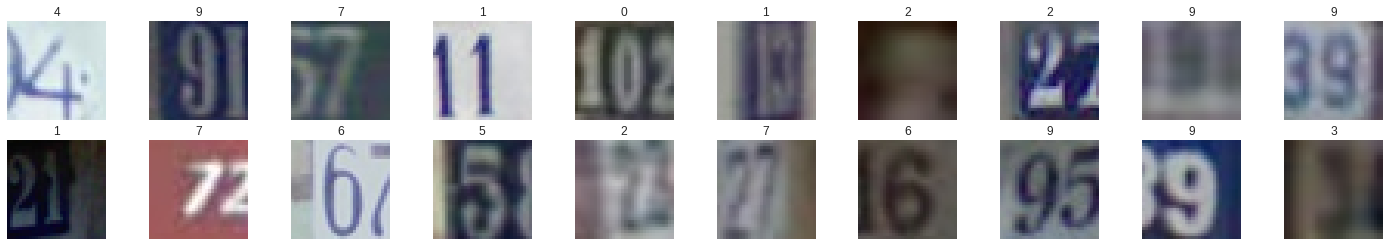

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    
    ax.set_title(str(labels[idx].item()))

In [4]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.3333)
Max:  tensor(1.)


In [0]:
def scale(x, feature_range=(-1, 1)):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [6]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.3333)
Scaled max:  tensor(1.)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    
    layers.append(conv_layer)

    if batch_norm:
        
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

In [11]:
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [12]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:

import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999


d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [15]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()


for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        
        real_images = scale(real_images)
        
        
        #            TRAIN THE DISCRIMINATOR
        
        
        d_optimizer.zero_grad()
        
        
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
                    
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #            TRAIN THE GENERATOR
        
        g_optimizer.zero_grad()
        
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        
        g_loss.backward()
        g_optimizer.step()

        
        if batch_i % print_every == 0:
            
            losses.append((d_loss.item(), g_loss.item()))
            
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode



with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.4098 | g_loss: 0.7341


182042624it [00:29, 22415346.33it/s]                               

Epoch [    1/  100] | d_loss: 0.1852 | g_loss: 4.0367
Epoch [    2/  100] | d_loss: 0.6310 | g_loss: 3.0048
Epoch [    2/  100] | d_loss: 0.5890 | g_loss: 3.1483
Epoch [    3/  100] | d_loss: 0.9418 | g_loss: 2.2025
Epoch [    3/  100] | d_loss: 0.5230 | g_loss: 1.3849
Epoch [    4/  100] | d_loss: 0.4945 | g_loss: 2.1604
Epoch [    4/  100] | d_loss: 0.5926 | g_loss: 2.6025
Epoch [    5/  100] | d_loss: 0.6471 | g_loss: 3.2376
Epoch [    5/  100] | d_loss: 0.4412 | g_loss: 3.2540
Epoch [    6/  100] | d_loss: 0.4106 | g_loss: 2.0296
Epoch [    6/  100] | d_loss: 0.4894 | g_loss: 2.3404
Epoch [    7/  100] | d_loss: 0.6122 | g_loss: 1.5571
Epoch [    7/  100] | d_loss: 0.4713 | g_loss: 1.9177
Epoch [    8/  100] | d_loss: 0.2709 | g_loss: 1.8952
Epoch [    8/  100] | d_loss: 0.3169 | g_loss: 2.5862
Epoch [    9/  100] | d_loss: 0.4529 | g_loss: 2.9568
Epoch [    9/  100] | d_loss: 0.5436 | g_loss: 2.8642
Epoch [   10/  100] | d_loss: 0.2338 | g_loss: 2.0234
Epoch [   10/  100] | d_loss

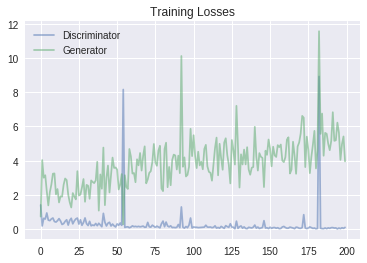

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

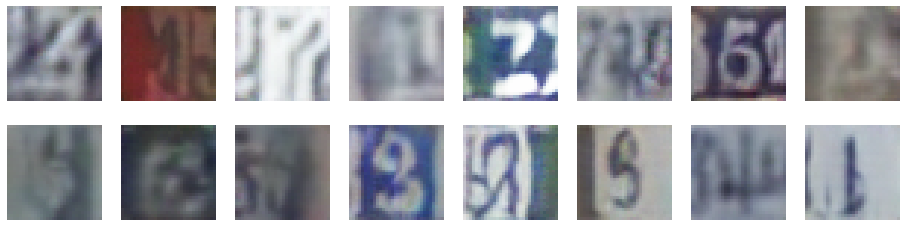

In [18]:
view_samples(-1, samples)

In [19]:
len(samples[0])

16

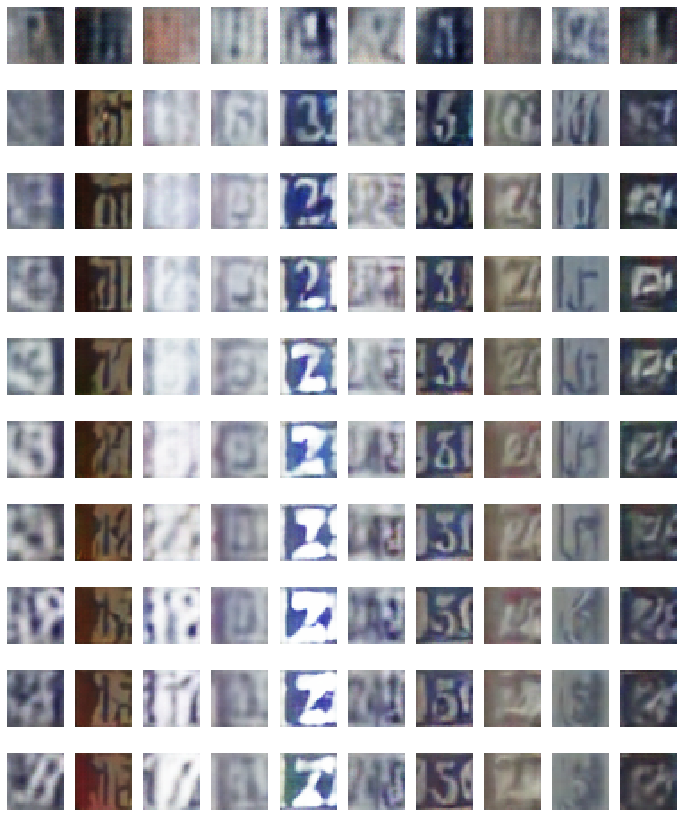

In [20]:
rows = 10
cols = 10
fig, axes = plt.subplots(figsize=(12,15), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

if train_on_gpu:
  rand_z = rand_z.cuda()
        

G.eval() 


rand_images = G(rand_z)

rand_images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[[[-0.0469, -0.0353, -0.0374,  ..., -0.0819,  0.0308,  0.0862],
          [-0.0517, -0.0912, -0.0953,  ..., -0.1527, -0.0232,  0.0511],
          [-0.0496, -0.0656, -0.0704,  ..., -0.2077, -0.0642,  0.0276],
          ...,
          [-0.5387, -0.5187, -0.4947,  ...,  0.0067, -0.0047, -0.0362],
          [-0.5184, -0.4912, -0.4469,  ...,  0.0143, -0.0096, -0.0230],
          [-0.4454, -0.4158, -0.3885,  ..., -0.0015, -0.0097, -0.0503]],

         [[-0.0586, -0.0604, -0.0560,  ..., -0.0624,  0.0476,  0.1062],
          [-0.0661, -0.0891, -0.0965,  ..., -0.1252,  0.0217,  0.1016],
          [-0.0469, -0.0638, -0.0737,  ..., -0.1608, -0.0265,  0.0712],
          ...,
          [-0.5043, -0.4701, -0.5045,  ...,  0.0335,  0.0346,  0.0221],
          [-0.5137, -0.4535, -0.4546,  ...,  0.0403,  0.0396,  0.0319],
          [-0.4388, -0.4330, -0.4044,  ...,  0.0202,  0.0124, -0.0279]],

         [[-0.0361, -0.0213, -0.0261,  ..., -0.0544,  0.0427,  0.0957],
          [-0.0509, -0.0650, -

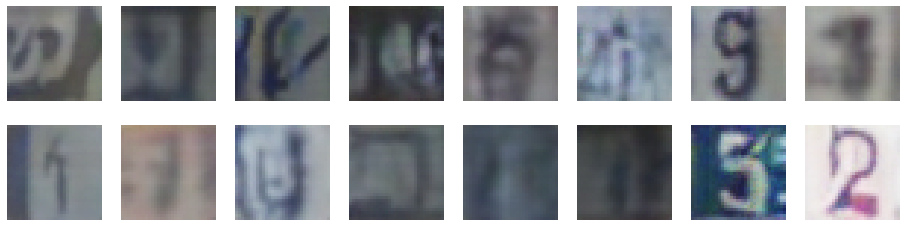

In [23]:
# 0 indicates the first set of samples in the passed in list

view_samples(0, [rand_images])